In [1]:
import warnings 

import xarray
import numpy as np
import metpy 
from cartopy import crs as ccrs
import matplotlib as M
import matplotlib.pyplot as plt 

from herbie import Herbie

# Use for "operations" 
warnings.filterwarnings(action='ignore')

In [2]:
def setup_herbie(inittime, fxx=0, product="nat", model="hrrr"):
    H = Herbie(
    inittime,
    model=model,
    product=product,
    fxx=fxx,
    )
    return H
    
def get_CONUS(qstr,herbie_inst):
    ds = herbie_inst.xarray(qstr)
    variables = [i for i in list(ds) if len(ds[i].dims) > 0]
    ds = ds.metpy.parse_cf(varname=variables).squeeze().metpy.assign_y_x()
    return ds 

def get_closest_point(ds,vrbl,lat,lon):
    grid_crs = ds[vrbl].metpy.cartopy_crs
    latlon_crs = ccrs.PlateCarree(globe=ds[vrbl].metpy.cartopy_globe)
    x_t, y_t = grid_crs.transform_point(lon, lat, src_crs=latlon_crs)
    return ds[vrbl].sel(x=x_t,y=y_t,method="nearest")

def crop_to_UB(ds,):
    # ds = ds.rename({'x':'west_east','y':'south_north'})

    sw_corner = (39.4, -110.9)
    ne_corner = (41.1, -108.5)
    lats = ds.latitude.values
    lons = ds.longitude.values
    
    if np.max(lons) > 180.0: 
        lons -= 360.0
    
    crop = xarray.DataArray(np.logical_and(np.logical_and(lats>sw_corner[0],
                         lats<ne_corner[0]),np.logical_and(lons>sw_corner[1],lons<ne_corner[1])),
                        # dims=['south_north','west_east'])
                            dims = ['y','x'])
    return ds.where(crop,drop=True)

def do_sfc_plot(ds,vrbl,minmax=None):
    # TODO: units and conversion elegantly!
    data = ds[vrbl]
    if vrbl == "t2m":
        # K to C
        data -= 273.15
    fig,ax = plt.subplots(1)
    cm = M.cm.cividis_r
    cm.set_bad(color='white')

    if minmax is None:
        im = ax.imshow(data[::-1,:])
    else:
        im = ax.imshow(data[::-1,:],vmin=minmax[0],vmax=minmax[1],cmap=cm,)
    plt.colorbar(im)
    return fig,ax
    
def make_query_string(vrbl):
    pass 

def do_model_sounding(T_profile, Z_profile, xlim=None, ylim=None):
    fig,ax = plt.subplots(1)
    ax.plot(T_profile, Z_profile)
    if ylim is not None:
        ax.set_ylim(ylim)
    if xlim is not None:
        ax.set_xlim(xlim)
    return fig,ax

# Dictionary for variable names?

In [3]:
inittimes = [
                "2023-11-23 12:00",
                    # "2022-12-14 00:00",
                # "2023-01-01 00:00",
                #     "2023-01-14 00:00",
                # "2023-02-01 00:00",
                # "2023-02-14 00:00",
                # "2023-03-01 00:00",
            ]
fxx = [6,12,18,24]
q_snod = ":SNOD:"

✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Nov-23 12:00 UTC F06 ┊ GRIB2 @ aws ┊ IDX @ aws
👨🏻‍🏭 Created directory: [/Users/johnlawson/data/hrrr/20231123]
✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Nov-23 12:00 UTC F12 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Nov-23 12:00 UTC F18 ┊ GRIB2 @ aws ┊ IDX @ aws
✅ Found ┊ model=hrrr ┊ product=nat ┊ 2023-Nov-23 12:00 UTC F24 ┊ GRIB2 @ aws ┊ IDX @ aws


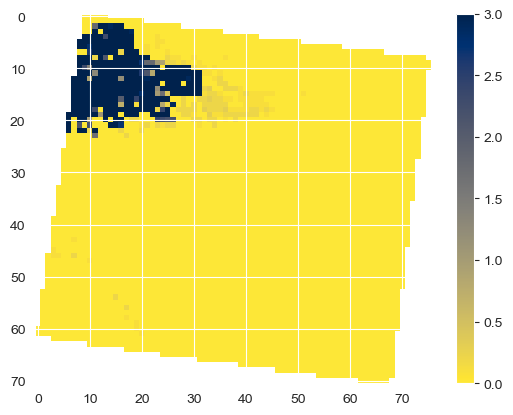

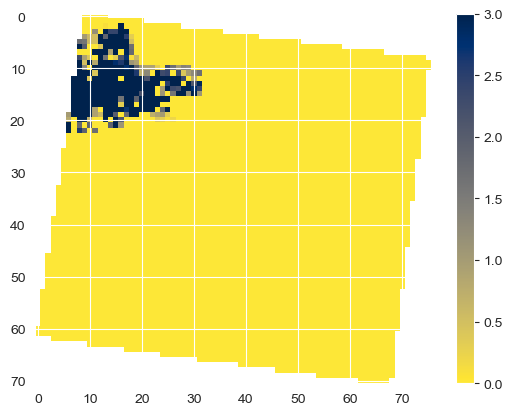

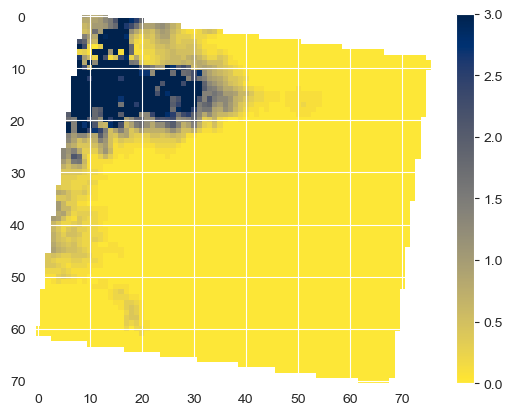

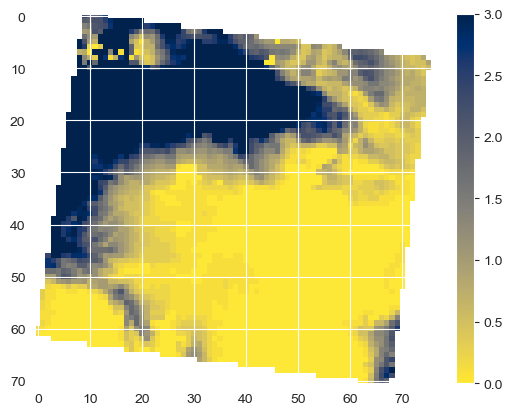

In [4]:
for inittime in inittimes:
    for fx in fxx:
        H = setup_herbie(inittime, fxx=fx)
        ds_snod = get_CONUS(q_snod, H)
        ds_snod_crop = crop_to_UB(ds_snod) * 100 # cm
        fig,ax = do_sfc_plot(ds_snod_crop,"sde",minmax=(0,3))

In [5]:
# Extract multiple time series
# Visualise at same valid times 